In [63]:
%matplotlib inline
#%matplotlib notebook

In [64]:
import cytoflow as flow
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
matplotlib.rc('figure', dpi = 160)

# Import samples and specify experimental condtions

In [65]:
inputs = [
    ["Experiment_Tube_005_005.fcs",0,0,'WT'],
    ["Experiment_Tube_006_006.fcs",1e-4, 0,'WT'],
    ["Experiment_Tube_007_007.fcs",1e-4, 1e-3,'Lux'],
    ["Experiment_Tube_009_009.fcs",1e-6, 1e-3,'Lux'],
    ["Experiment_Tube_010_010.fcs",1e-8, 1e-3,'Lux'],
    ["Experiment_Tube_011_011.fcs",1e-10, 1e-3,'Lux'],
    ["Experiment_Tube_012_012.fcs",1e-12,1e-3,'Lux'],
    ["Experiment_Tube_013_013.fcs",1e-4,0,'Lux'],
    ["Experiment_Tube_014_014.fcs",1e-6, 0,'Lux'],
    ["Experiment_Tube_015_015.fcs",1e-8, 0,'Lux'],
    ["Experiment_Tube_016_016.fcs",1e-10, 0,'Lux'],
    ["Experiment_Tube_017_017.fcs",1e-12, 0,'Lux'],
 
]

       
tubes = []
for filename, ahl, iptg, family in inputs:
    tubes.append(flow.Tube(file = 'data/' + filename, conditions = {'AHL' : ahl, 'IPTG' : iptg, 'Family' : family}))
    
ex = flow.ImportOp(conditions = {'AHL' : 'float', 'IPTG' : 'float', 'Family' : 'str'},
                   tubes = tubes).apply()
       


In [66]:
flow.set_default_scale("log")

## Effect of fixation time on mNG intensity

# Plot FITC-A histograms for all IPTG and AHL induction conditions

C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10


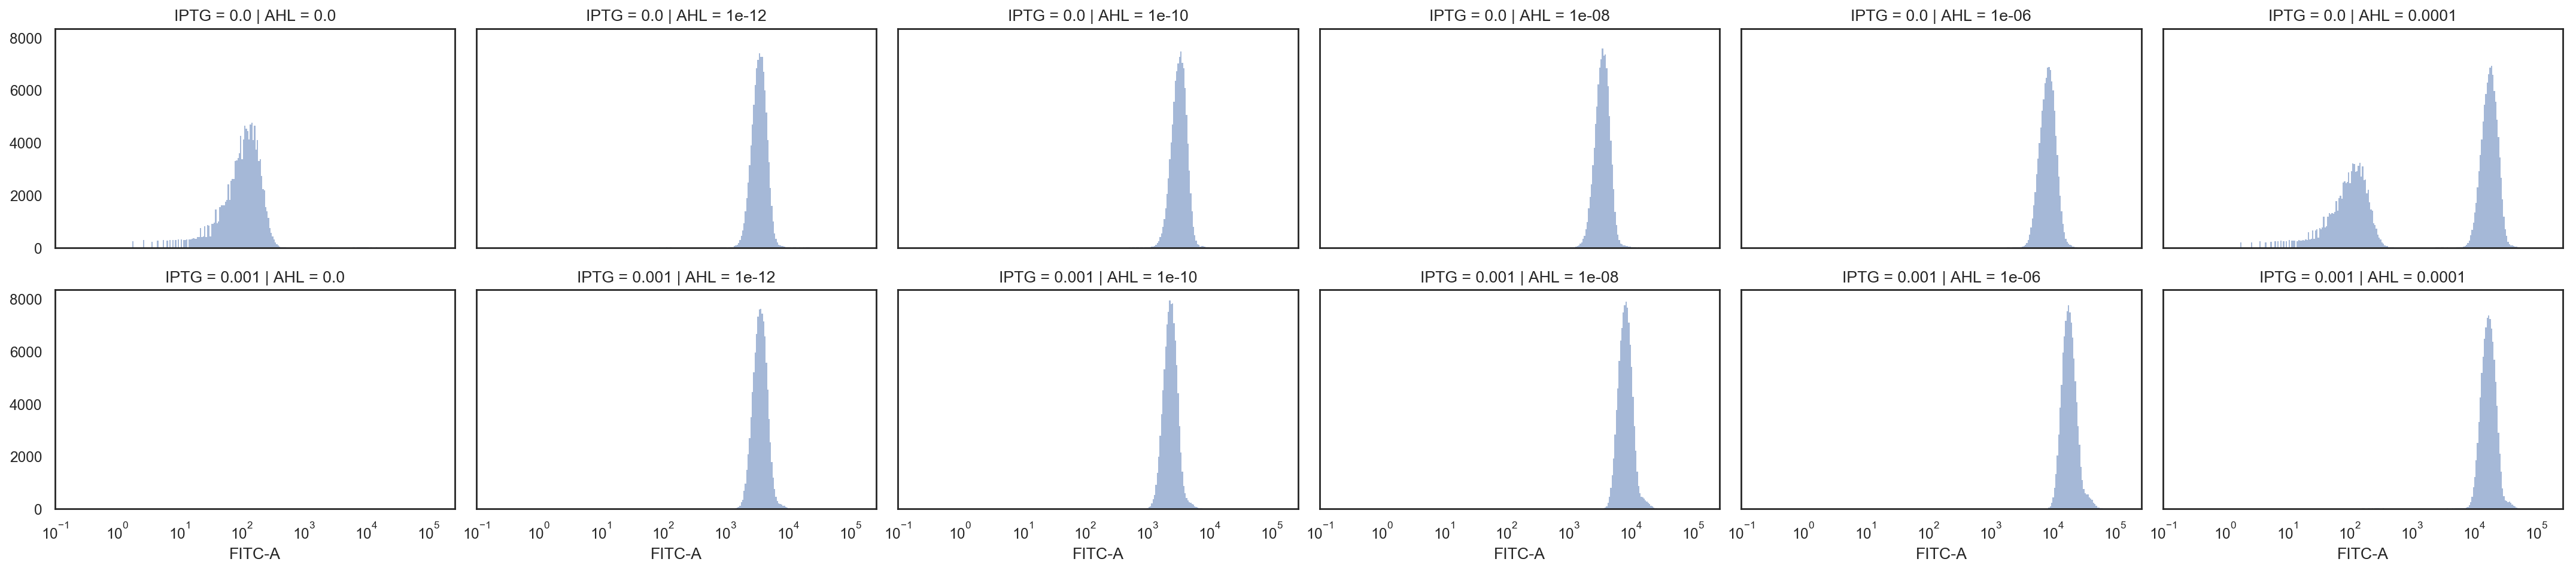

In [67]:

flow.HistogramView(channel = "FITC-A",
                   xfacet = "AHL",
                  yfacet = 'IPTG').plot(ex)

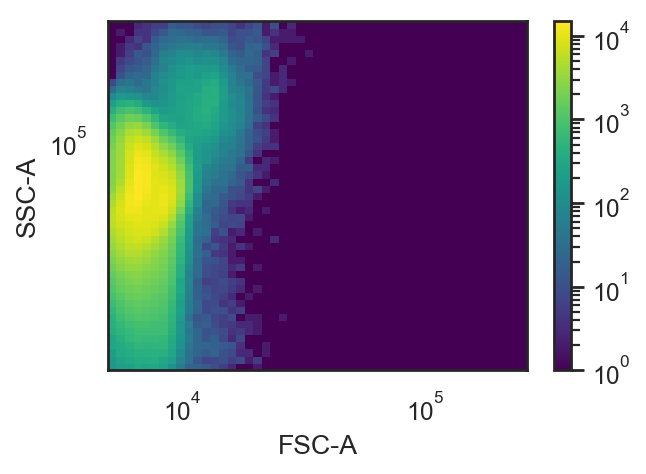

In [68]:
flow.DensityView(xchannel = "FSC-A", 
                 ychannel = "SSC-A",
                 xscale = 'log',
                 yscale = 'log').plot(ex, min_quantile = 0.005)

# Singlet gating to remove doublets

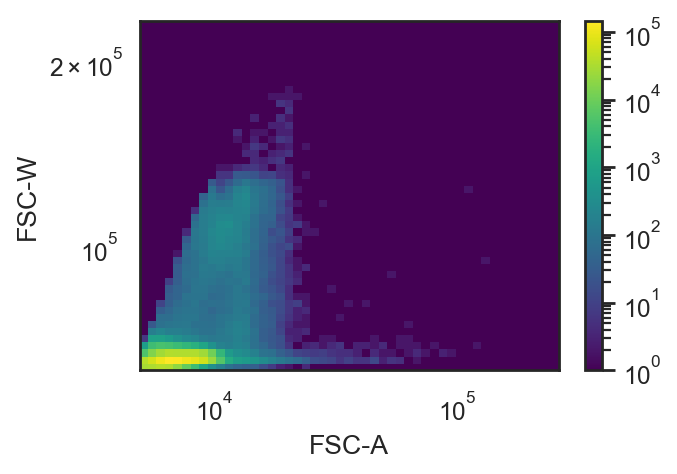

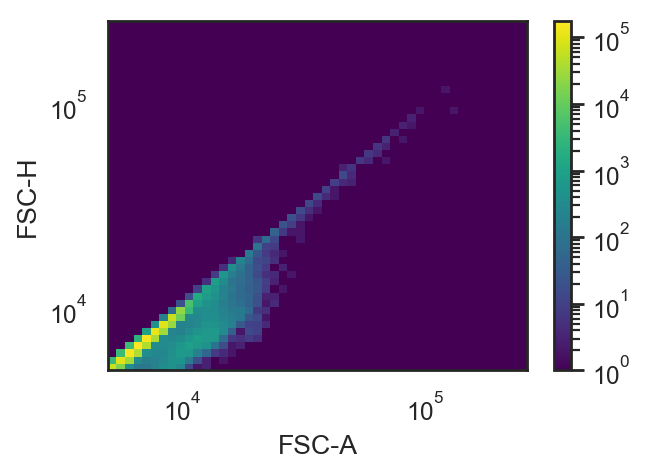

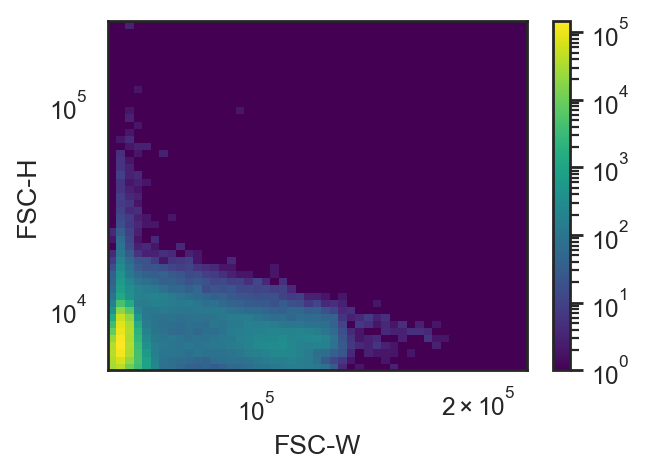

In [69]:

#channels = ['FSC-A','FSC-W','FSC-H','SSC-A','SSC-W','SSC-H']
#perm = combinations(channels,2)
FSC = [('FSC-A','FSC-W'),('FSC-A','FSC-H'),('FSC-W','FSC-H')]

#f, axes = plt.subplots(ncols=4,nrows=4)
#axs = axes.ravel()
for i,(x,y) in enumerate(FSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'log',
                yscale = 'log').plot(ex, min_quantile = 0.005)


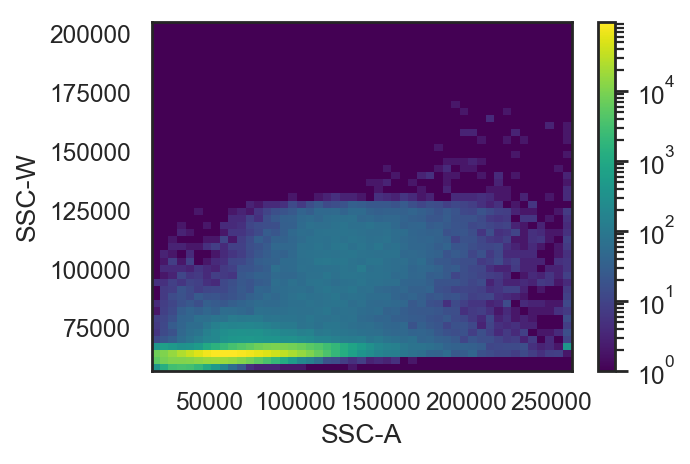

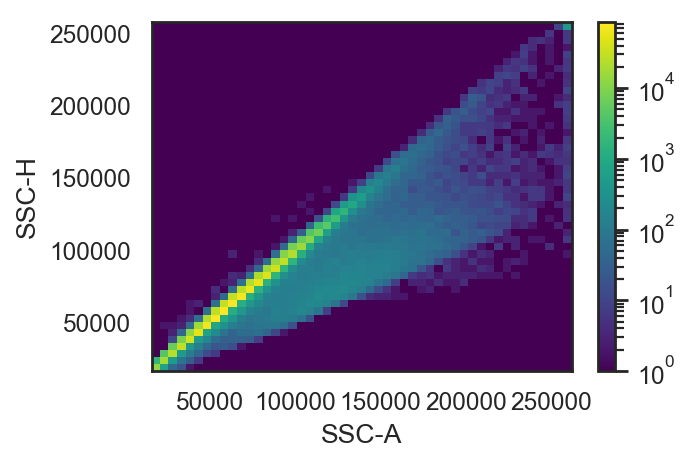

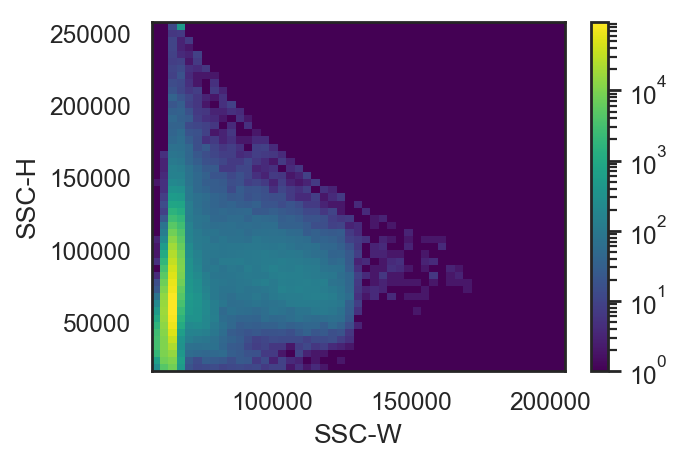

In [70]:
SSC = [('SSC-A','SSC-W'),('SSC-A','SSC-H'),('SSC-W','SSC-H')]
for i,(x,y) in enumerate(SSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'linear',
                yscale = 'linear').plot(ex, min_quantile = 0.005)

## Create and store singlet gate

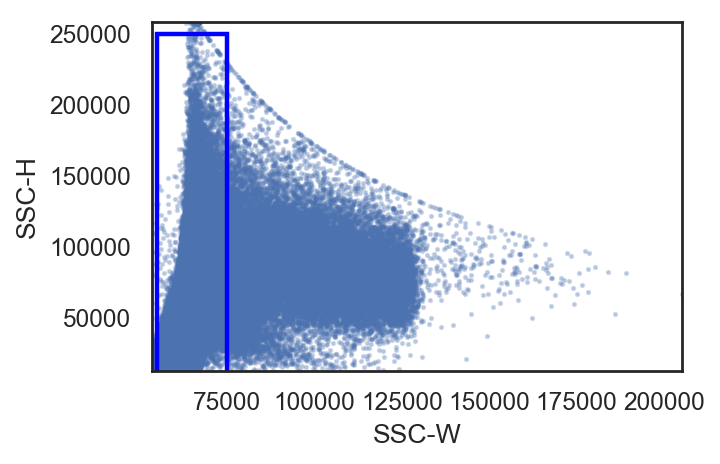

In [71]:
r = flow.Range2DOp(name = "Range2D",
                   xchannel = "SSC-W",
                   xlow = 55000,
                   xhigh = 75000,
                   ychannel = "SSC-H",
                   ylow = 5000,
                   yhigh = 250000)
                   
rv = r.default_view(xscale ='linear',yscale='linear')

rv.plot(ex)
ex2 = r.apply(ex)

## Use a gaussian mixture model to further gate the population

C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM_1'


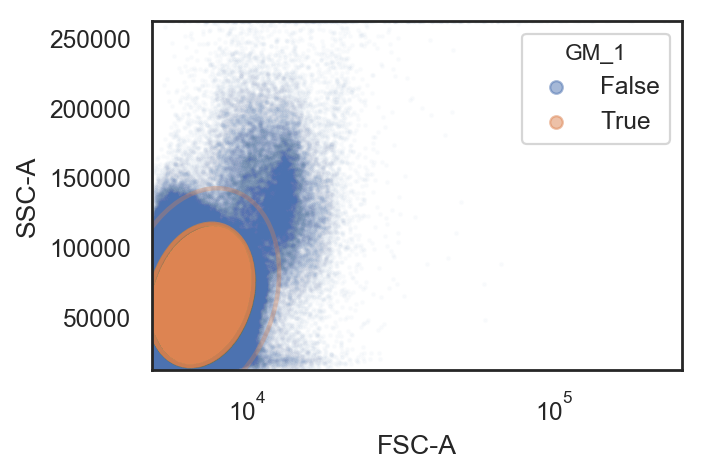

In [72]:
gm = flow.GaussianMixtureOp(name = "GM",
                            channels = ['FSC-A', 'SSC-A'],
                            scale = {'FSC-A' : 'log',
                                     'SSC-A' : 'linear'},
                            num_components = 1,
                            sigma = 2)
gm.estimate(ex2)
ex_gm = gm.apply(ex2)
gm.default_view().plot(ex_gm, alpha = 0.02)

C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\gaussian.py:529: RuntimeWarning: invalid value encountered in less_equal
C:\Users\Jonathan\anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM3_1'


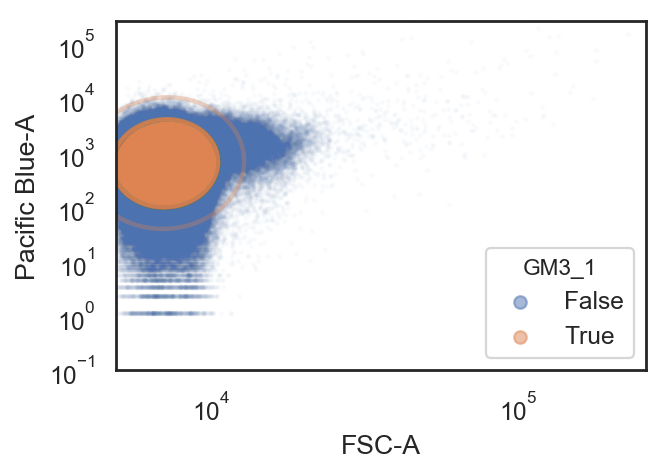

In [73]:
gm3 = flow.GaussianMixtureOp(name = "GM3",
                            channels = ['FSC-A', 'Pacific Blue-A'],
                            scale = {'FSC-A' : 'log',
                                     'Pacific Blue-A' : 'log'},
                            num_components = 1,
                            sigma = 2)
gm3.estimate(ex_gm)
ex_gm2 = gm3.apply(ex_gm)
gm3.default_view().plot(ex_gm2, alpha = 0.02)

In [74]:
df =ex_gm2.data

# filter out events that don't fall within the gates

In [75]:

df = df[(df.GM_1==True) & (df.GM3_1==True) & (df.Range2D==True) & (df['FITC-A'] >0)]
df

,AHL,FITC-A,FITC-H,FITC-W,FSC-A,FSC-H,FSC-W,Family,IPTG,Pacific Blue-A,...,Pacific Blue-W,PerCP-Cy5-5-A,PerCP-Cy5-5-H,SSC-A,SSC-H,SSC-W,Time,Range2D,GM_1,GM3_1
0,0.000000e+00,141.509995,112.0,82803.554688,5285.080078,5364.0,64571.773438,WT,0.0,641.700012,...,75097.234375,11102.750000,11380.0,32790.269531,36144.0,59455.042969,52.200001,True,True,True
1,0.000000e+00,25.809999,99.0,17085.697266,5224.399902,5287.0,64760.031250,WT,0.0,1240.849976,...,62029.250000,7614.839844,7151.0,49845.339844,51991.0,62831.339844,52.200001,True,True,True
3,0.000000e+00,169.989990,298.0,37384.109375,7594.620117,7646.0,65095.609375,WT,0.0,1514.549927,...,61919.863281,14042.419922,13431.0,86477.742188,87738.0,64594.652344,52.299999,True,True,True
5,0.000000e+00,188.679993,290.0,42639.078125,6767.300293,6694.0,66253.632812,WT,0.0,1269.599976,...,47008.195312,14737.509766,13934.0,104496.679688,105362.0,64997.765625,52.500000,True,True,True
6,0.000000e+00,47.169998,146.0,21173.513672,5157.060059,5206.0,64919.917969,WT,0.0,882.049988,...,77800.843750,8974.759766,9319.0,34941.398438,36566.0,62624.285156,52.500000,True,True,True
7,0.000000e+00,113.919998,66.0,113119.109375,5632.140137,5750.0,64192.683594,WT,0.0,2664.550049,...,70726.593750,9010.359375,8709.0,58063.597656,57974.0,65637.281250,52.599998,True,True,True
8,0.000000e+00,70.309998,118.0,39049.457031,6362.520020,6450.0,64647.144531,WT,0.0,783.149963,...,32218.779297,9924.389648,10206.0,60223.628906,62229.0,63424.058594,52.700001,True,True,True
9,0.000000e+00,209.149994,228.0,60117.777344,6286.300293,6368.0,64695.191406,WT,0.0,1159.199951,...,59443.914062,10073.910156,9802.0,101044.367188,103188.0,64174.554688,52.700001,True,True,True
10,0.000000e+00,210.039993,246.0,55956.019531,7132.859863,7170.0,65196.535156,WT,0.0,2428.800049,...,57215.617188,15332.029297,15482.0,106264.218750,108150.0,64393.269531,52.799999,True,True,True
11,0.000000e+00,121.040001,51.0,155538.781250,6987.080078,7223.0,63395.445312,WT,0.0,363.399994,...,27002.021484,8314.379883,8838.0,70467.531250,73303.0,63000.968750,52.799999,True,True,True


In [76]:
import scipy.stats as stats
import scipy as sp
from scipy.stats.mstats import gmean
import numpy as np

def geom_sd(a):
    a = np.array(a)
    u = gmean(a)
    a[a <= 0] = np.abs(a[a <= 0]) + 2 * u
    
    return np.exp(np.std(np.log(a)))
def geom_sem(a):
    a = np.array(a)
    u = geom_mean(a)
    a[a <= 0] = np.abs(a[a <= 0]) + 2 * u
def geom_std(values):
    """
    Calculates the geometric standard deviation for the passed values.
    Source: https://en.wikipedia.org/wiki/Geometric_standard_deviation
    """

   # gmean = stats.gmean(values)
    return sp.exp(sp.sqrt(sp.sum([sp.log(x / gmean(values)) ** 2 for x in values]) / len(values))) 


In [77]:
data = df[['FITC-A','AHL','IPTG','Family']]
data.insert(4,'Replicate',2)
data.to_pickle('../compiled-data/se/lux/LuxSE_2.pkl')


# Plot mean FITC-A

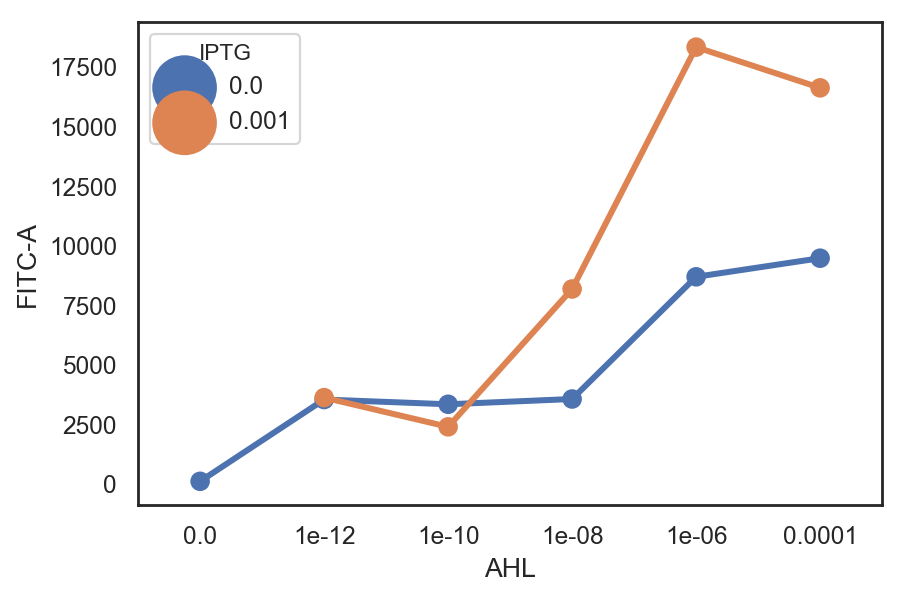

In [78]:
sns.pointplot(x='AHL',y='FITC-A',hue='IPTG',data=df)

In [79]:
gb = df.groupby(['AHL','IPTG'])
mean = df.groupby(['AHL','IPTG'])['FITC-A'].apply(gmean).reset_index()
geostd = df.groupby(['AHL','IPTG'])['FITC-A'].apply(geom_sd).reset_index()

std = df.groupby(['AHL','IPTG'])['FITC-A'].std().reset_index()


# Plot Geometric mean FITC-A

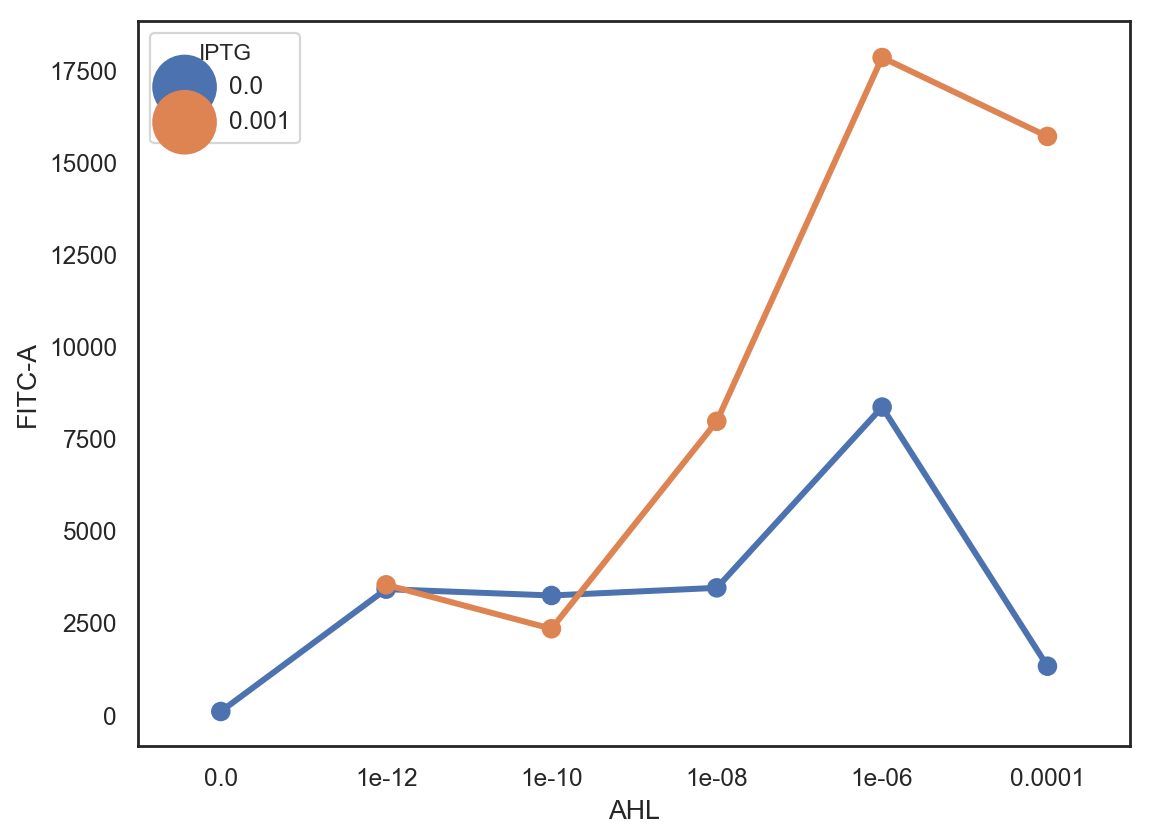

In [80]:
f, ax = plt.subplots(figsize=(8,6))
sns.pointplot(x='AHL',y='FITC-A',hue='IPTG',estimator=gmean,ci=0.01,data=df)
f.savefig('Lux.png',dpi=600)

In [81]:
mean

,AHL,IPTG,FITC-A
0,0.000000e+00,0.000,87.410181
1,1.000000e-12,0.000,3408.650316
2,1.000000e-12,0.001,3526.703824
3,1.000000e-10,0.000,3237.155354
4,1.000000e-10,0.001,2333.458719
5,1.000000e-08,0.000,3444.413663
6,1.000000e-08,0.001,7966.254391
7,1.000000e-06,0.000,8352.352043
8,1.000000e-06,0.001,17842.530997
9,1.000000e-04,0.000,1316.996786


# Calculate standard deviation percentages

In [82]:
std['FITC-A']/mean['FITC-A']*100

0     483.653542
1      31.611968
2      25.425325
3      26.929241
4      28.735846
5      28.764661
6      24.163811
7      28.970878
8      23.547529
9     741.270046
10     27.255161
Name: FITC-A, dtype: float64

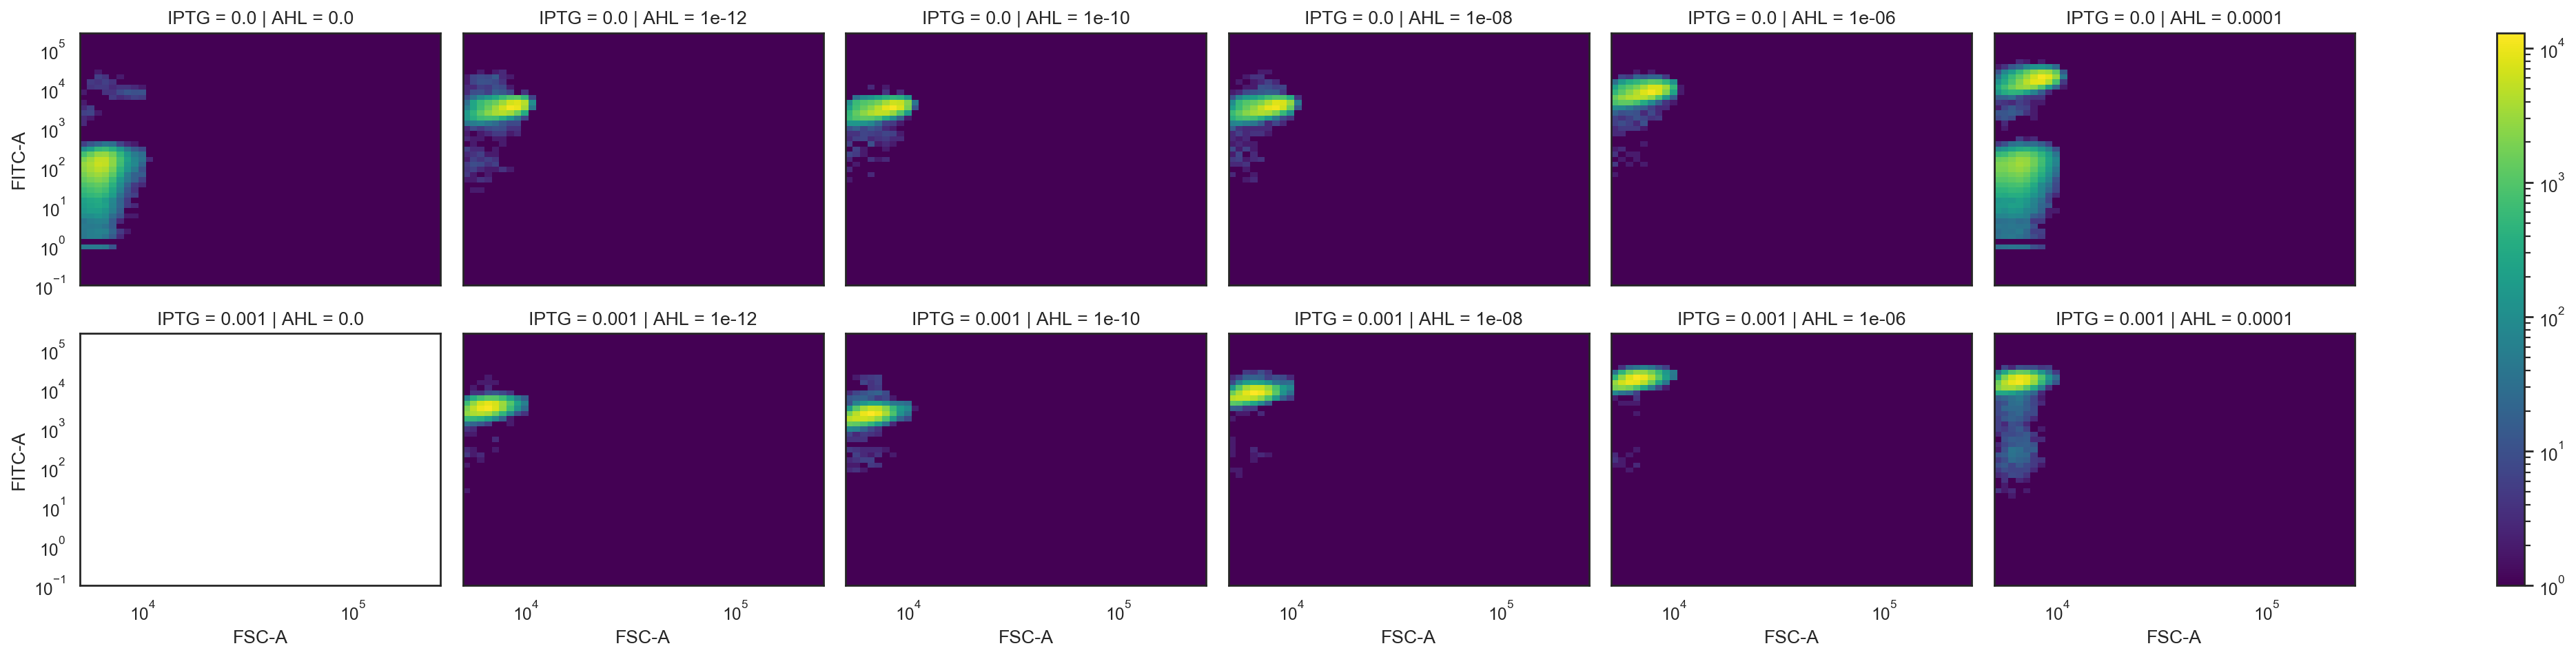

In [83]:

flow.DensityView(xchannel = 'FSC-A', 
                ychannel = 'FITC-A',
                   xfacet = "AHL",
                yfacet='IPTG',
                 subset = 'GM_1 == True').plot(ex_gm2, min_quantile = 0.01)

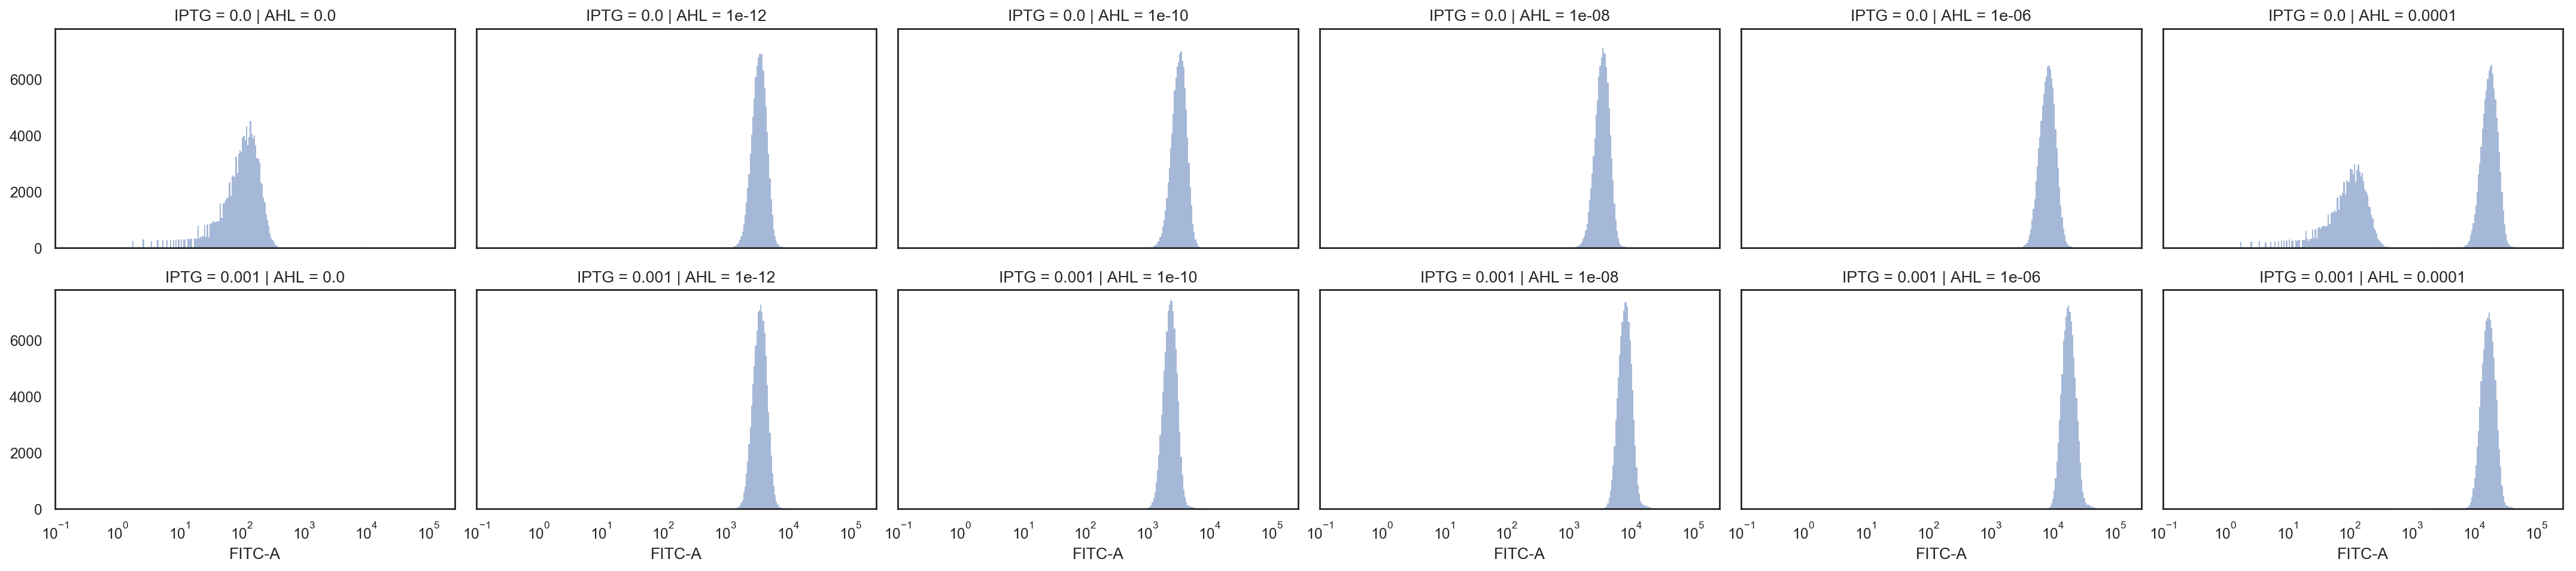

In [84]:
flow.HistogramView(channel = 'FITC-A',
                   xfacet = "AHL",
                yfacet='IPTG',
                 subset = 'Range2D == True').plot(ex_gm2, min_quantile = 0.01)

# Plot heatmaps showing absolute and relative induction

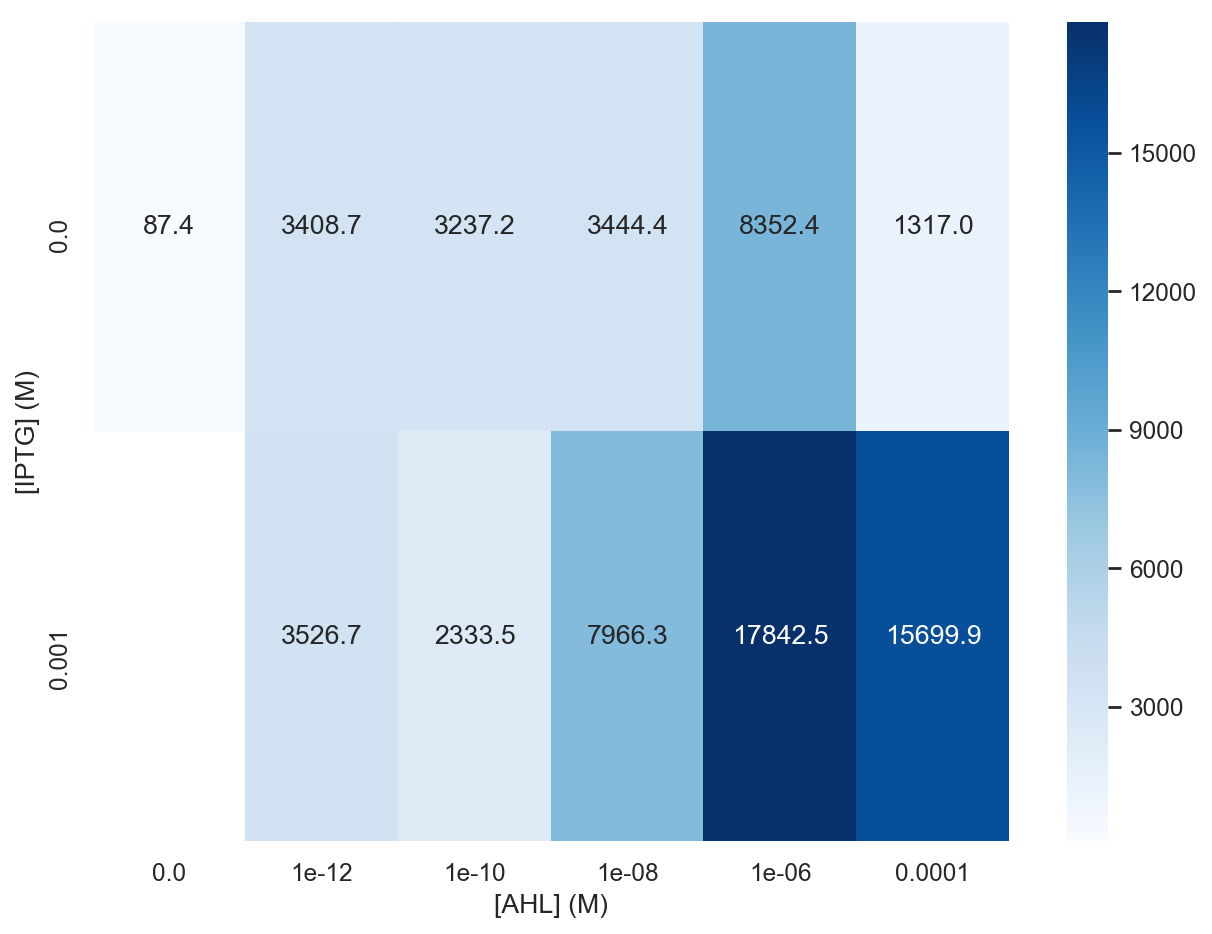

In [85]:
#LasMeans = Las.groupby(['C_ahl','C_iptg']).mean().reset_index()
sns.set(style="white")
#sns.set_style('Talk')
#LasTable = pd.pivot_table(LasMeans,values='FITC-A',index='C_iptg',columns='C_ahl')
f, ax = plt.subplots(figsize=(8,6))
#g = sns.heatmap(LasTable,vmin=0,vmax=100,xticklabels=[0,1e-10,1e-9,1e-7],yticklabels=[0,1e-3,1e-4,1e-5],ax=ax,square=True,cmap='Reds')



#f.savefig('LasHeatmap.png',dpi=600)
mean = df.groupby(['AHL','IPTG'])['FITC-A'].apply(gmean).reset_index()
#mean['FITC-A']=mean['FITC-A']/mean['FITC-A'].max()*100

piv = mean.pivot_table(index='IPTG', columns='AHL', values='FITC-A')
g = sns.heatmap(piv, annot=True, fmt=".1f",cmap='Blues')
cbar = g.collections[0].colorbar
#cbar.set_ticks([0, 25, 50, 75,100])
#cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlabel(r'[AHL] (M)')
ax.set_ylabel(r'[IPTG] (M)')
f.tight_layout()

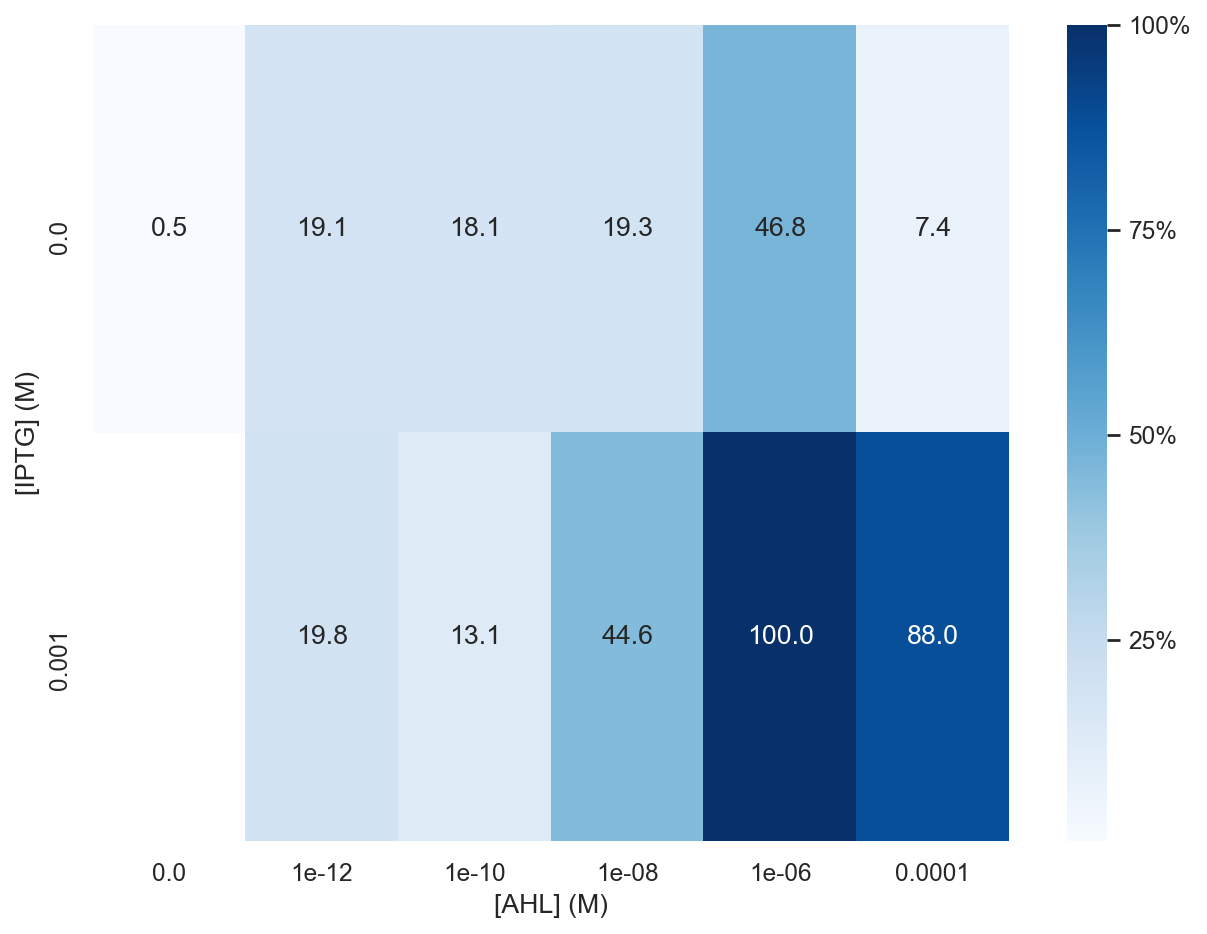

In [86]:
f, ax = plt.subplots(figsize=(8,6))
# normalized
mean['FITC-A']=mean['FITC-A']/mean['FITC-A'].max()*100

piv = mean.pivot_table(index='IPTG', columns='AHL', values='FITC-A')
g = sns.heatmap(piv, annot=True, fmt=".1f",cmap='Blues')
cbar = g.collections[0].colorbar
cbar.set_ticks([0, 25, 50, 75,100])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlabel(r'[AHL] (M)')
ax.set_ylabel(r'[IPTG] (M)')
f.tight_layout()

# Calculate the on/off ratio and plot

In [87]:

R =[]
for i in mean.IPTG.unique():
    tmp = mean[mean.IPTG ==i]['FITC-A'].max()/mean[mean.IPTG ==i]['FITC-A'].min()
    R.append([i,tmp])



In [88]:

R = pd.DataFrame(R,columns=['IPTG','Induction Ratio'])
R

,IPTG,Induction Ratio
0,0.000,95.553538
1,0.001,7.646388


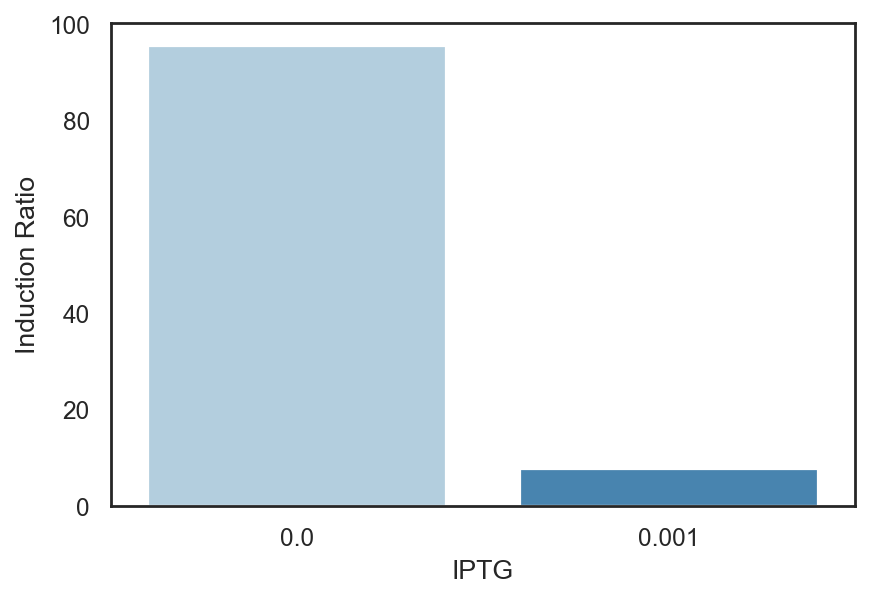

In [89]:
f, ax  = plt.subplots()
sns.barplot(x='IPTG',y='Induction Ratio',data=R,palette='Blues')

# Fit data to logistic function

In [90]:
import scipy.optimize as opt
mean = df.groupby(['AHL','IPTG'])['FITC-A'].apply(gmean).reset_index()
data = mean.copy()
data.AHL[data.AHL == 0]=1e-14


In [91]:
data

,AHL,IPTG,FITC-A
0,1.000000e-14,0.000,87.410181
1,1.000000e-12,0.000,3408.650316
2,1.000000e-12,0.001,3526.703824
3,1.000000e-10,0.000,3237.155354
4,1.000000e-10,0.001,2333.458719
5,1.000000e-08,0.000,3444.413663
6,1.000000e-08,0.001,7966.254391
7,1.000000e-06,0.000,8352.352043
8,1.000000e-06,0.001,17842.530997
9,1.000000e-04,0.000,1316.996786


NameError: name 'axes' is not defined

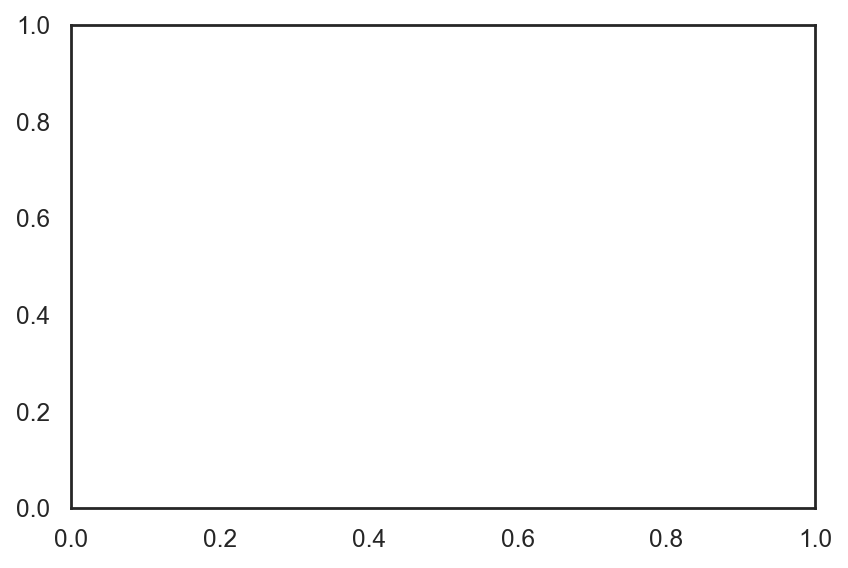

In [92]:
colors = ['#deebf7','#9ecae1','#3182bd']
fig, ax = plt.subplots(figsize=(6, 4))
axs = axes.ravel()
for i,iptg in enumerate(data.IPTG.unique()):
    tmp = data[data.IPTG==iptg]
    def func(x, a, b):
        return (tmp['FITC-A'].max() -tmp['FITC-A'].min()) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + tmp['FITC-A'].min()
    (a_, b_), _ = opt.curve_fit(func, tmp.AHL, tmp['FITC-A'],p0=[1,1e-9],maxfev=10000000)
    n = 1e6
    x = np.linspace(tmp.AHL.min(), tmp.AHL.max(), n)
    print(a_,b_)
    y_fit = func(x, a_, b_)

    
    ax.plot(np.log10(tmp.AHL.values), tmp['FITC-A'].values, 'o',color = colors[i])
    ax.plot(np.log10(x), y_fit, '-',color = colors[i])
plt.show()

In [ ]:
tmp.AHL

In [ ]:
#a, c = np.random.exponential(size=2,scale=1e4)
#b, d = np.random.randn(2)
a,b,c,d = 5000,1000,1e2,1e-5
n = 100
#x = np.linspace(-12, -4, n)
x = np.logspace(-12,-4,n)
y_model = f(x, a, b, c, d)
y = y_model + a * .2 * np.random.randn(n)
#(a_, b_, c_, d_), _ = opt.curve_fit(f, x, y,p0=[1e4,1,1,d])
#y_fit = f(x, a_, b_, c_, d_)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x, y_model, '--k')
ax.plot(x, y, 'o')
#ax.plot(x, y_fit, '-')
plt.xscale('log')



In [ ]:
print(a_, b_, c_, d_)

In [ ]:
np.log10(0)

In [ ]:
x

In [ ]:
data


In [ ]:
df.AHL.unique()

In [ ]:
df[df.AHL==1e-4]['FITC-A']

In [ ]:
sns.kdeplot(df[df.AHL==1e-4]['FITC-A'])

In [ ]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
#rs = np.random.RandomState(1979)
#x = rs.randn(500)
#g = np.tile(list("ABCDEFGHIJ"), 50)
#df = pd.DataFrame(dict(x=x, g=g))
#m = df.g.map(ord)
#df["x"] += m
tmpdf = df[df.IPTG==0][['AHL','FITC-A']]
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(tmpdf, row="AHL", hue="AHL", aspect=5, height=0.5, palette=pal)
g.set(xlim=(0, 20000))
# Draw the densities in a few steps
g.map(sns.kdeplot, "FITC-A", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "FITC-A", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "FITC-A")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

